In [27]:
import tensorflow as T
from tensorflow import *
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import *
import numpy as np
import pandas as pd
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
T.random.set_seed(42)

In [2]:
import os 
import io
from tensorboard.plugins.hparams import api as hp

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
print("Num GPUs Available: ", len(T.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
#Import train, validation and test sets

training = './data/random_split/train_fold_0.csv'
validation = './data/random_split/valid_fold_0.csv'
test = './data/random_split/test_fold_0.csv'


train_dataset = pd.read_csv(training, delimiter=',', low_memory=False)
val_dataset = pd.read_csv(validation, delimiter=',', low_memory=False)
test_dataset = pd.read_csv(test, delimiter=',', low_memory=False)


train_dataset.head()

,ID,SMILES,pLoaelfinal_Cholecystitis,pLoaelfinal_Abnormal-Hepatic-Fun,pLoaelfinal_Cholelitiasis,pLoaelfinal_Cholestasiss,pLoaelfinal_cholestatic Jaundice,pLoaelfinal_Hepatic necrosis,pLoaelfinal_Hepatic Steatosis,pLoaelfinal_Hepatitis,pLoaelfinal_HepatoBiliary disorder,pLoaelfinal_HepatoCellular-injury,pLoaelfinal_Hepatomegaly,pLoaelfinal_Hepatotoxicity,pLoaelfinal_Hyperbilirubinemia,pLoaelfinal_Jaundice,pLoaelfinal_Liver-Injury
0,691,CC(C)OC1=C(NC2=NC=C(Cl)C(NC3=C(S(=O)(=O)C(C)C)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.789131,2.828778,2.776599,NaN
1,497,CN1CCCC(CN2C3=CC=CC=C3SC3=CC=CC=C32)C1,NaN,NaN,NaN,NaN,2.750075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20,COC12CCC3(CC1C(C)(O)C(C)(C)C)C1CC4=CC=C(O)C5=C...,4.572479,NaN,3.995286,NaN,NaN,4.852882,NaN,4.31547,4.396696,NaN,NaN,NaN,NaN,NaN,3.187071
3,769,CC1=CN(C2=CC(C(F)(F)F)=CC(NC(=O)C3=CC(NC4=NC=C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.727683,3.126536,3.054477,NaN
4,133,CC(N=C(NC#N)NC1=CC=NC=C1)C(C)(C)C,5.157395,3.32652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

In [7]:
def molecule_from_smiles(SMILES):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(SMILES, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(SMILES_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for SMILES in SMILES_list:
        molecule = molecule_from_smiles(SMILES)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for T.data.Dataset later on
    return (
        T.ragged.constant(atom_features_list, dtype = T.float32),
        T.ragged.constant(bond_features_list, dtype = T.float32),
        T.ragged.constant(pair_indices_list, dtype = T.int64),
    )

In [8]:
task_start=2
tasks=15
task_index = tasks + 2
print('tasks: %s' % tasks)


# load training dataset with augmentation
X_train = graphs_from_smiles(train_dataset.iloc[:,1].values)
y_train = np.array(train_dataset.iloc[:,2:task_index].values)
print(f"loaded training data: {y_train.shape}")

# load test dataset
X_test = graphs_from_smiles(test_dataset.iloc[:,1].values)
y_test = np.array(test_dataset.iloc[:,2:task_index].values)
print(f"loaded test data: {y_test.shape}")

# load test dataset
X_val = graphs_from_smiles(val_dataset.iloc[:,1].values)
y_val = np.array(val_dataset.iloc[:,2:task_index].values)
print(f"loaded val data: {y_val.shape}")

tasks: 15
loaded training data: (750, 15)
loaded test data: (161, 15)
loaded val data: (161, 15)


In [11]:
molecule = molecule_from_smiles(train_dataset.iloc[8].SMILES)
molecule

graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (24, 29)
	bond features	 (76, 7)
	pair indices	 (76, 2)


In [12]:
def prepare_batch(X_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = X_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = T.range(len(num_atoms))
    molecule_indicator = T.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = T.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = T.cumsum(num_atoms[:-1])
    increment = T.pad(T.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, T.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = T.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

In [13]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = T.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = T.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = T.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = T.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = T.matmul(bond_features, atom_features_neighbors)
        transformed_features = T.squeeze(transformed_features, axis=-1)
        aggregated_features = T.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments = T.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = T.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated

In [14]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = T.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [T.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = T.reduce_max(num_atoms)
        atom_features_stacked = T.stack(
            [
                T.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = T.where(T.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = T.squeeze(gather_indices, axis=-1)
        return T.gather(atom_features_stacked, gather_indices, axis=0)

    
class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = T.reduce_any(T.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, T.newaxis, T.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)
    
    


In [15]:
# custom loss function for missing values in input data (i.e. target labels or values)
def custom_loss(y_true, y_pred):

    y_true = T.where(T.math.is_nan(y_true), T.zeros_like(y_true), y_true)
    loss = T.reduce_mean(
       T.where(T.equal(y_true, 0.0), y_true,
       T.square(T.abs(y_true - y_pred))))
    return loss


# Task weights used in class_weight function
mt_df=pd.DataFrame(y_train)

weights = []

for col in mt_df.columns.values:
    c = mt_df[mt_df[col] >= 0.0].shape[0]
    weights.append(1/c)
weights = np.array(weights)
weight = weights.tolist()
weight = pd.DataFrame(weight)
weight = weight.T
weight.dropna(inplace=True)
test = weight.to_dict('index')
test_dict=dict(test)
dct1={}
for key in test_dict[0]:
      dct1[key]=test_dict[0][key]
print(dct1)


cw = np.nan_to_num(y_train)
cw1 = (len(y_train)/cw.sum(axis=0)/10)
cw1 = cw1.tolist()
cw1 = pd.DataFrame(cw1)
cw2 = cw1.to_dict('index')
dct2={}
for key in cw2:
      dct2[key]=cw2[key][0]
print(dct2)

{0: 0.007575757575757576,
 1: 0.004484304932735426,
 2: 0.005813953488372093,
 3: 0.008771929824561403,
 4: 0.017241379310344827,
 5: 0.009900990099009901,
 6: 0.009433962264150943,
 7: 0.0034602076124567475,
 8: 0.017857142857142856,
 9: 0.008130081300813009,
 10: 0.008928571428571428,
 11: 0.007142857142857143,
 12: 0.006369426751592357,
 13: 0.004032258064516129,
 14: 0.011235955056179775}
{0: 0.14796893041560372,
 1: 0.09065118229556045,
 2: 0.11673649421595182,
 3: 0.16562856817958377,
 4: 0.34747745445558353,
 5: 0.19722785305750704,
 6: 0.18160392991343474,
 7: 0.06959276695029251,
 8: 0.34287170272884077,
 9: 0.16457767040926533,
 10: 0.19752784397644213,
 11: 0.13897268483663658,
 12: 0.12440443746422303,
 13: 0.07900947108215223,
 14: 0.22003296015728271}


In [16]:
message_units=32
message_steps=4
num_attention_heads=8
dense_units=512


def MPNNModel(atom_dim, bond_dim):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)([atom_features, bond_features, pair_indices])
    x = TransformerEncoderReadout(num_attention_heads, message_units, dense_units)([x, molecule_indicator])
    x = T.keras.layers.Dense(50, activation="relu")(x)
    x = T.keras.layers.Dense(tasks, activation="linear")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x])
    return model


model = MPNNModel(atom_dim=X_train[0][0][0].shape[0], bond_dim=X_train[1][0][0].shape[0])
model.compile(loss=custom_loss,optimizer=Adam(learning_rate=5e-4))
model.summary()
T.keras.utils.plot_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atom_features (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 bond_features (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 pair_indices (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 message_passing (MessagePassin  (None, 32)          14528       ['atom_features[0][0]',          
 g)                                                               'bond_features[0][0]',      

Epoch 1/1000
24/24 - 6s - loss: 0.1022 - val_loss: 0.1464 - 6s/epoch - 270ms/step
Epoch 2/1000
24/24 - 5s - loss: 0.1010 - val_loss: 0.1467 - 5s/epoch - 212ms/step
Epoch 3/1000
24/24 - 5s - loss: 0.0994 - val_loss: 0.1472 - 5s/epoch - 222ms/step
Epoch 4/1000
24/24 - 5s - loss: 0.0983 - val_loss: 0.1456 - 5s/epoch - 218ms/step
Epoch 5/1000
24/24 - 5s - loss: 0.0971 - val_loss: 0.1451 - 5s/epoch - 222ms/step
Epoch 6/1000
24/24 - 5s - loss: 0.0964 - val_loss: 0.1422 - 5s/epoch - 223ms/step
Epoch 7/1000
24/24 - 5s - loss: 0.0938 - val_loss: 0.1398 - 5s/epoch - 219ms/step
Epoch 8/1000
24/24 - 5s - loss: 0.0927 - val_loss: 0.1392 - 5s/epoch - 218ms/step
Epoch 9/1000
24/24 - 5s - loss: 0.0926 - val_loss: 0.1404 - 5s/epoch - 221ms/step
Epoch 10/1000
24/24 - 5s - loss: 0.0933 - val_loss: 0.1429 - 5s/epoch - 212ms/step
Epoch 11/1000
24/24 - 5s - loss: 0.0922 - val_loss: 0.1466 - 5s/epoch - 222ms/step
Epoch 12/1000
24/24 - 5s - loss: 0.0899 - val_loss: 0.1523 - 5s/epoch - 216ms/step
Epoch 13/1000

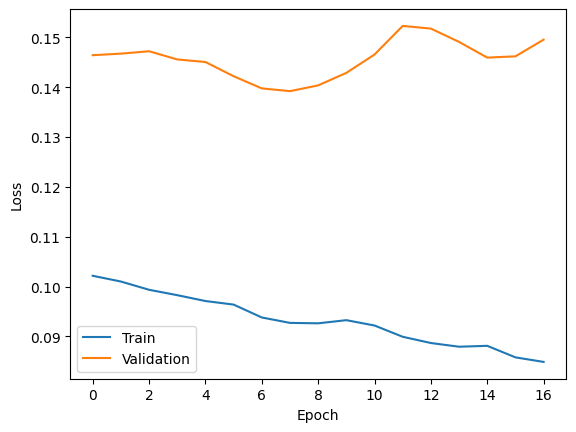

In [24]:
train_model = MPNNDataset(X_train, y_train)
val_model = MPNNDataset(X_val, y_val)
test_model = MPNNDataset(X_test, y_test)

# Early stopping parameters

callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00000001, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="./data/ST-FNN_regression_model", monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='min', verbose=1)
    ]


# parameters for train network

epochs=1000
batch_size=32

history = model.fit(
    train_model,
    validation_data=val_dataset,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    #class_weight=dct1,
    callbacks=(early_stopping))

pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Validation')
pyplot.legend()
pyplot.ylabel('Loss') 
pyplot.xlabel('Epoch') 
pyplot.show()

6/6 [==============================] - 1s 144ms/step
Results for task 1 (train)
r^2	0.60
rmse	0.62
mse	0.39
mae	0.49
Results for task 1 (validation)
r^2	0.53
rmse	0.76
mse	0.58
mae	0.53
Results for task 1 (test)
r^2	0.35
rmse	0.74
mse	0.55
mae	0.57
Results for task 2 (train)
r^2	0.72
rmse	0.69
mse	0.48
mae	0.53
Results for task 2 (validation)
r^2	0.57
rmse	0.90
mse	0.81
mae	0.69
Results for task 2 (test)
r^2	0.59
rmse	0.83
mse	0.69
mae	0.61
Results for task 3 (train)
r^2	0.63
rmse	0.57
mse	0.33
mae	0.44
Results for task 3 (validation)
r^2	0.46
rmse	0.74
mse	0.55
mae	0.60
Results for task 3 (test)
r^2	0.04
rmse	0.80
mse	0.64
mae	0.57
Results for task 4 (train)
r^2	0.66
rmse	0.59
mse	0.35
mae	0.46
Results for task 4 (validation)
r^2	0.25
rmse	0.65
mse	0.43
mae	0.49
Results for task 4 (test)
r^2	0.41
rmse	0.64
mse	0.41
mae	0.52
Results for task 5 (train)
r^2	0.71
rmse	0.70
mse	0.50
mae	0.57
Results for task 5 (validation)
r^2	0.43
rmse	1.02
mse	1.05
mae	0.90
Results for task 5 (test)
r^2	

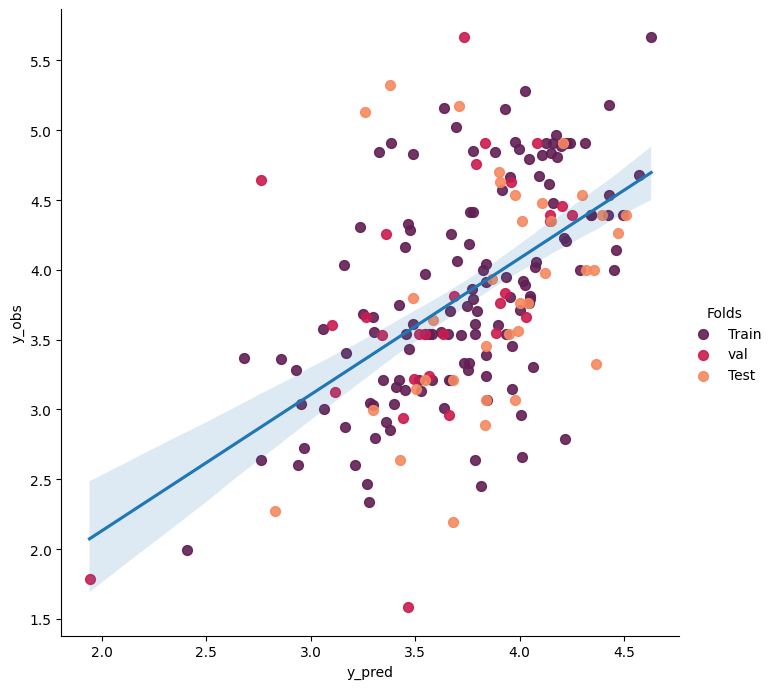

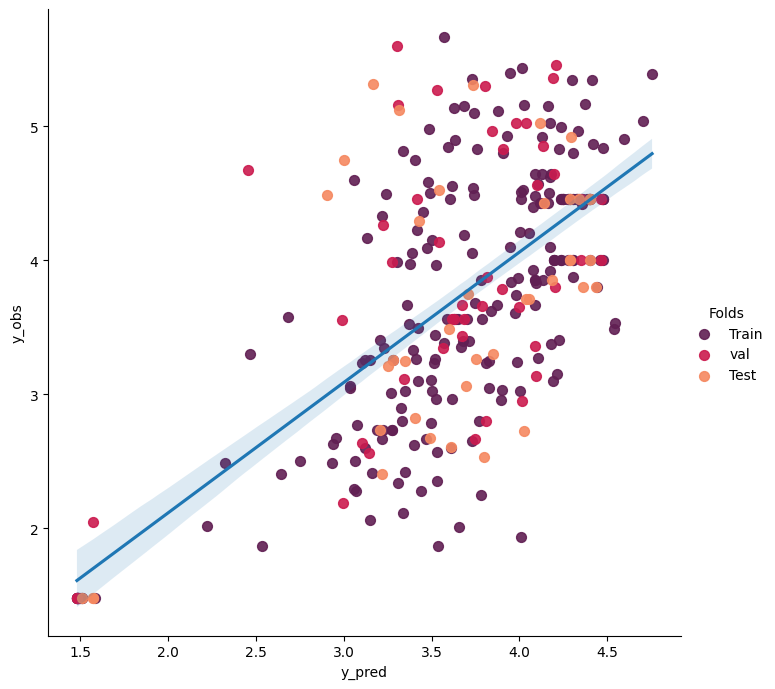

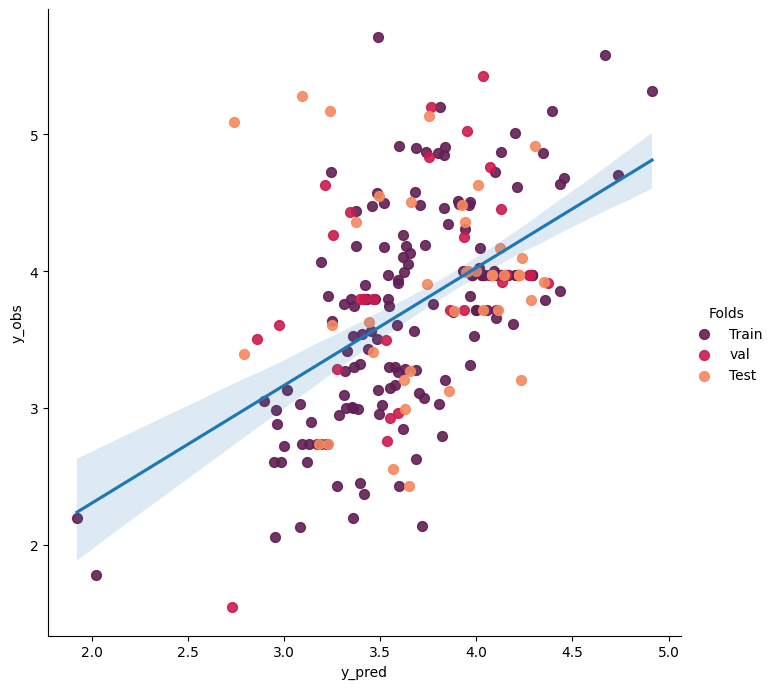

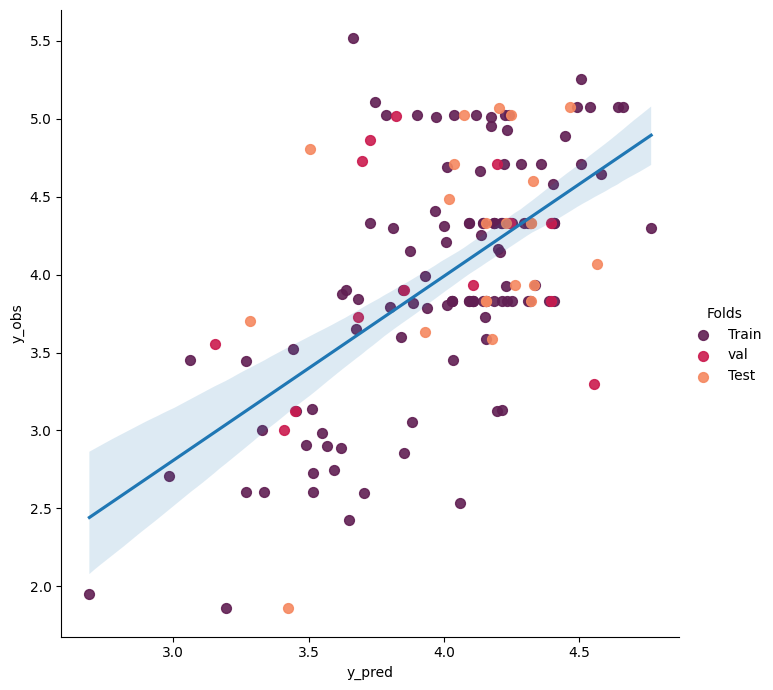

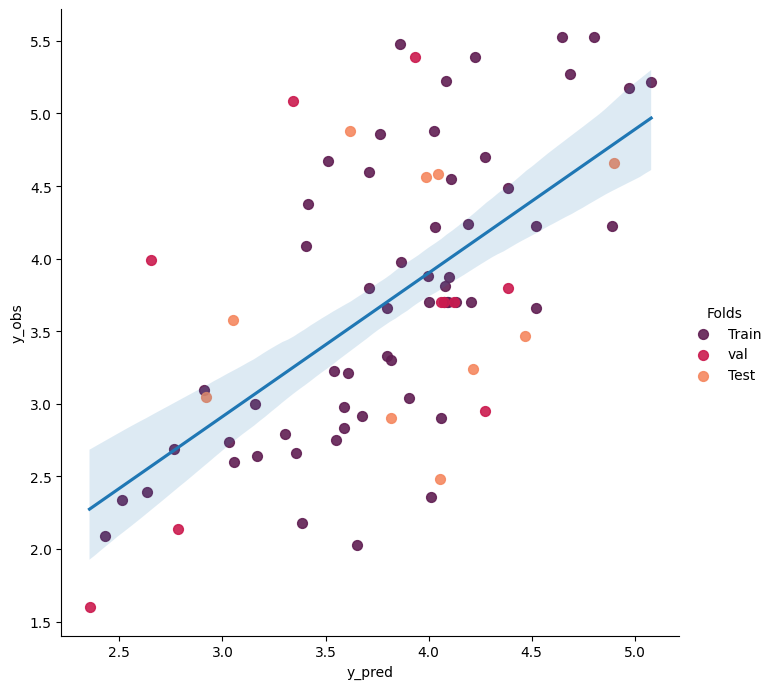

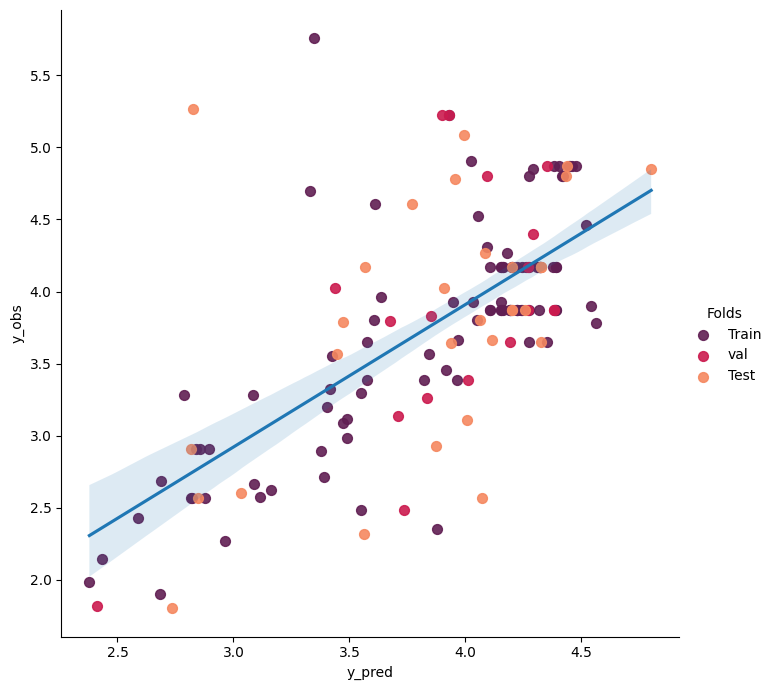

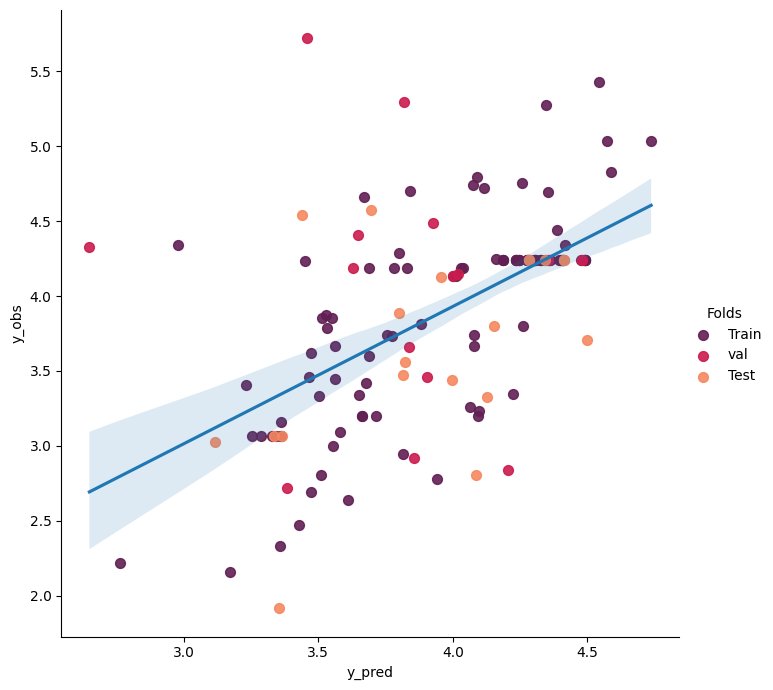

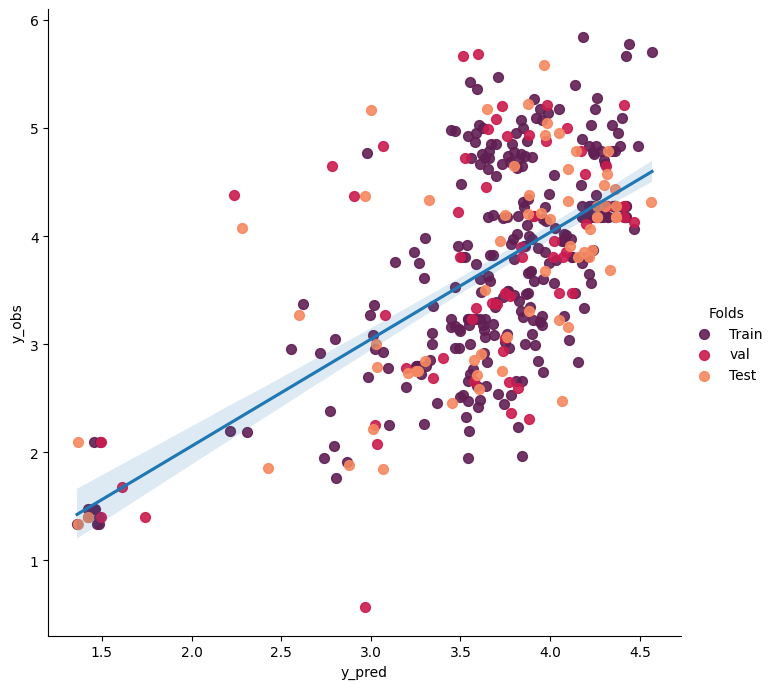

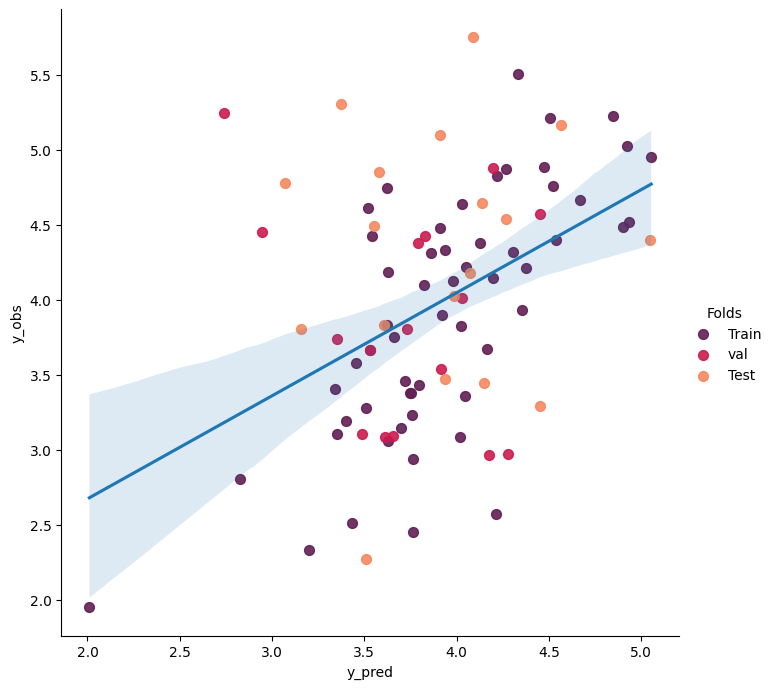

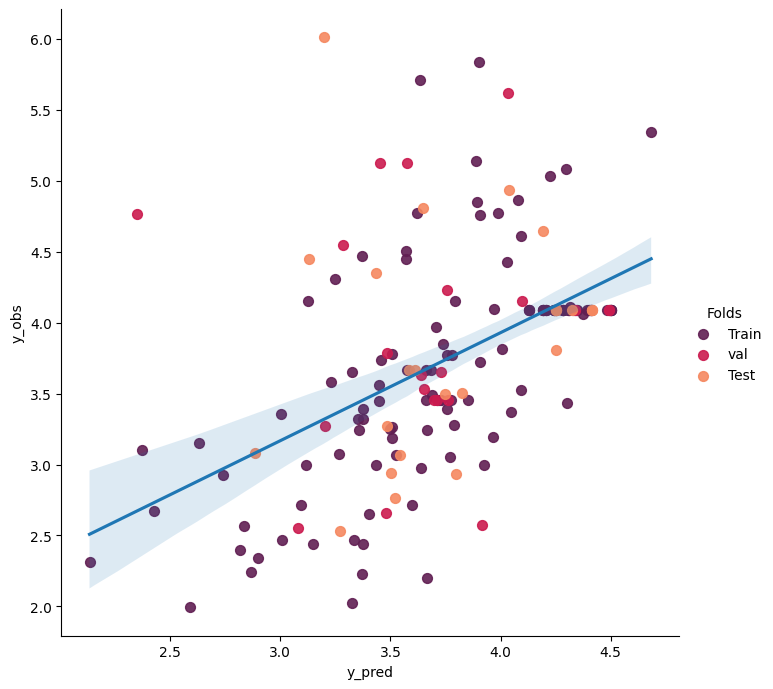

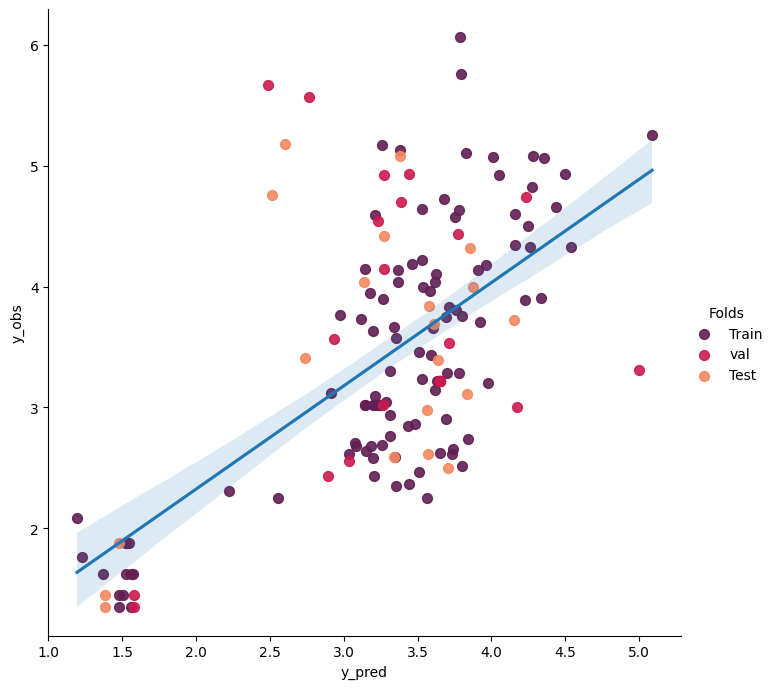

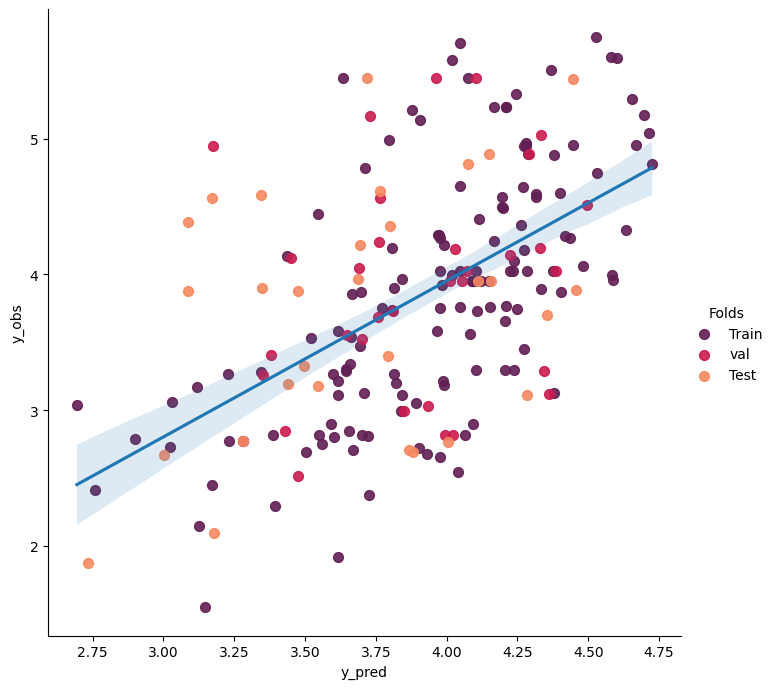

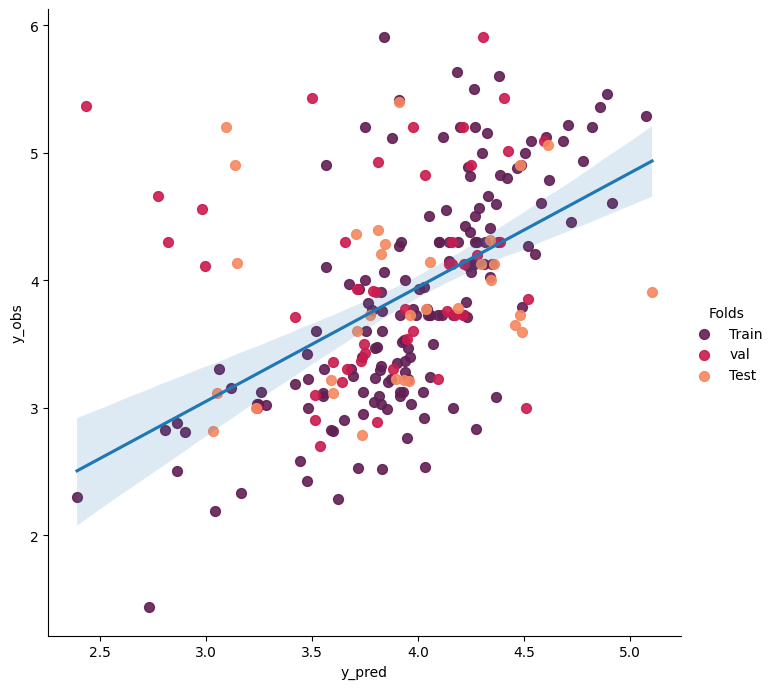

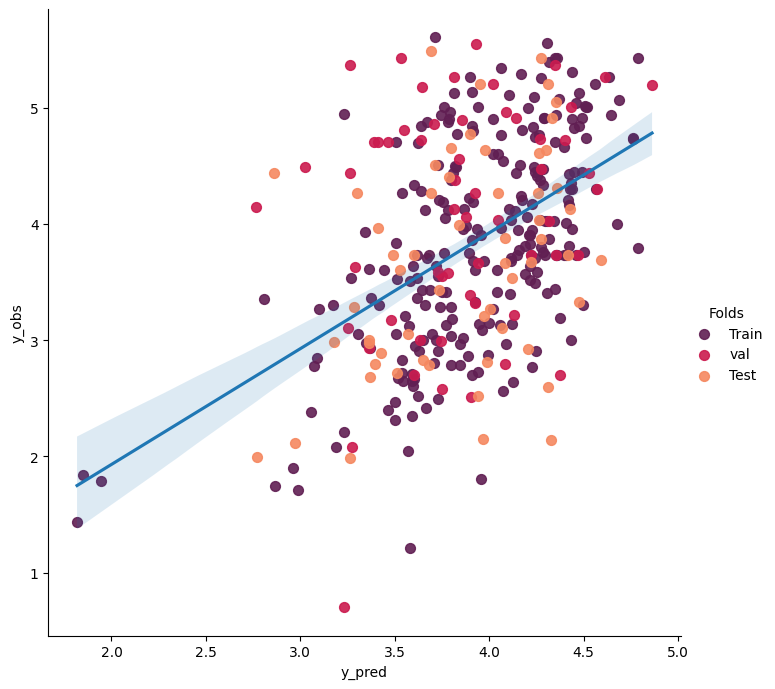

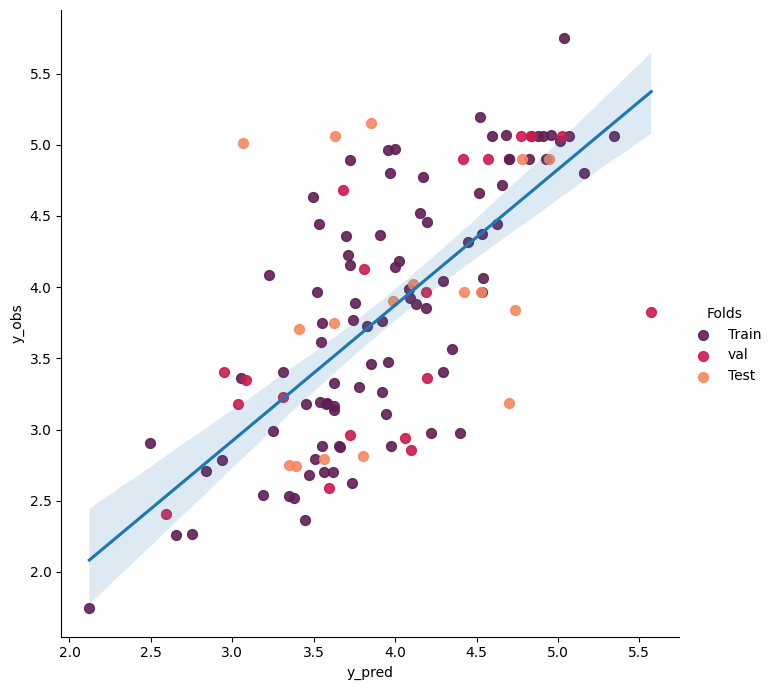

In [29]:
#Statistical characteristico of model without 3-sigma rule

prediction_train = model.predict(train_model)
prediction_val = model.predict(val_model)
prediction_test = model.predict(test_model)


for index1 in range(prediction_train.shape[1]):

    train_pred = pd.DataFrame(y_train[:,index1],prediction_train[:,index1]) 
    train_pred['y_pred'] = train_pred.index
    train_pred = train_pred.rename(columns = {0: 'y_obs'})
    train_pred2 = train_pred.dropna()
    train_pred2 = train_pred2.reset_index(drop=True)
    train_pred2['Folds'] = 'Train'
    train_pred2 = train_pred2.assign(Folds_error = abs(train_pred2['y_pred'] - train_pred2['y_obs']))
    train_pred2['Folds error Mean'] = train_pred2['Folds_error'].mean() 
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds_error'].std()
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds error 3*sigma']*3

    for index2 in range(prediction_val.shape[1]):
         
        val_pred = pd.DataFrame(y_val[:,index2],prediction_val[:,index2])
        val_pred['y_pred'] = val_pred.index
        val_pred = val_pred.rename(columns = {0: 'y_obs'})
        val_pred2 = val_pred.dropna()
        val_pred2 = val_pred2.reset_index(drop=True)
        val_pred2['Folds'] = 'val'
        val_pred2 = val_pred2.assign(Folds_error = abs(val_pred2['y_pred'] - val_pred2['y_obs']))
        val_pred2['Folds error Mean'] = val_pred2['Folds_error'].mean() 
        val_pred2['Folds error 3*sigma'] = val_pred2['Folds_error'].std()
        val_pred2['Folds error 3*sigma'] = val_pred2['Folds error 3*sigma']*3
          
        for index3 in range(prediction_test.shape[1]):
         
            test_pred = pd.DataFrame(y_test[:,index3],prediction_test[:,index3])
            test_pred['y_pred'] = test_pred.index
            test_pred = test_pred.rename(columns = {0: 'y_obs'})
            test_pred2 = test_pred.dropna()
            test_pred2 = test_pred2.reset_index(drop=True)
            test_pred2['Folds'] = 'Test'
            test_pred2 = test_pred2.assign(Folds_error = abs(test_pred2['y_pred'] - test_pred2['y_obs']))
            test_pred2['Folds error Mean'] = test_pred2['Folds_error'].mean() 
            test_pred2['Folds error 3*sigma'] = test_pred2['Folds_error'].std()
            test_pred2['Folds error 3*sigma'] = test_pred2['Folds error 3*sigma']*3

            crossval_df = pd.concat([train_pred2, val_pred2, test_pred2], axis=0).reset_index(drop=True)

            if index1 == index2 and index1 == index3:
                    
                r2  = (train_pred2["y_obs"].corr(train_pred2["y_pred"]))    
                print(("Results for task {} (train)").format(index2+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f" % sqrt(mean_squared_error(train_pred2["y_obs"],train_pred2["y_pred"])))
                print ("mse\t%.2f" % (mean_squared_error(train_pred2["y_obs"],train_pred2["y_pred"])))
                print ("mae\t%.2f"  %mean_absolute_error(train_pred2["y_obs"],train_pred2["y_pred"]))   

                r2 = (val_pred2["y_obs"].corr(val_pred2["y_pred"]))
                print(("Results for task {} (validation)").format(index3+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f"  % sqrt(mean_squared_error(val_pred2["y_pred"],val_pred2["y_obs"])))
                print ("mse\t%.2f"  % (mean_squared_error(val_pred2["y_pred"],val_pred2["y_obs"])))
                print ("mae\t%.2f"  % mean_absolute_error(val_pred2["y_pred"],val_pred2["y_obs"]))
                
                r2 = (test_pred2["y_obs"].corr(test_pred2["y_pred"])) 
                print(("Results for task {} (test)").format(index1+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f"  % sqrt(mean_squared_error(test_pred2["y_pred"],test_pred2["y_obs"]))) 
                print ("mse\t%.2f"  % (mean_squared_error(test_pred2["y_pred"],test_pred2["y_obs"])))
                print ("mae\t%.2f"  % mean_absolute_error(test_pred2["y_pred"],test_pred2["y_obs"]))

                g = sns.lmplot(x="y_pred", y="y_obs", hue="Folds", data=crossval_df, fit_reg=False, height=7, 
                markers=["o", "o", "o"], palette="rocket",scatter_kws={"s": 50,'alpha':0.9},  aspect=30/30)
                sns.regplot(x="y_pred", y="y_obs", data=crossval_df, scatter=False, ax=g.axes[0, 0]) 

Results for task 1 (train)
r^2	0.71
rmse	0.51
mse	0.26
mae	0.42
Results for task 1 (validation)
r^2	0.76
rmse	0.48
mse	0.23
mae	0.37
Results for task 1 (test)
r^2	0.69
rmse	0.51
mse	0.26
mae	0.43
Results for task 2 (train)
r^2	0.79
rmse	0.58
mse	0.33
mae	0.46
Results for task 2 (validation)
r^2	0.69
rmse	0.74
mse	0.55
mae	0.59
Results for task 2 (test)
r^2	0.73
rmse	0.67
mse	0.45
mae	0.51
Results for task 3 (train)
r^2	0.71
rmse	0.48
mse	0.23
mae	0.39
Results for task 3 (validation)
r^2	0.53
rmse	0.61
mse	0.38
mae	0.51
Results for task 3 (test)
r^2	0.41
rmse	0.57
mse	0.33
mae	0.45
Results for task 4 (train)
r^2	0.74
rmse	0.48
mse	0.23
mae	0.39
Results for task 4 (validation)
r^2	0.25
rmse	0.65
mse	0.43
mae	0.49
Results for task 4 (test)
r^2	0.27
rmse	0.50
mse	0.25
mae	0.43
Results for task 5 (train)
r^2	0.77
rmse	0.61
mse	0.38
mae	0.52
Results for task 5 (validation)
r^2	0.55
rmse	0.91
mse	0.83
mae	0.81
Results for task 5 (test)
r^2	0.35
rmse	0.77
mse	0.59
mae	0.68
Results for task 6 (

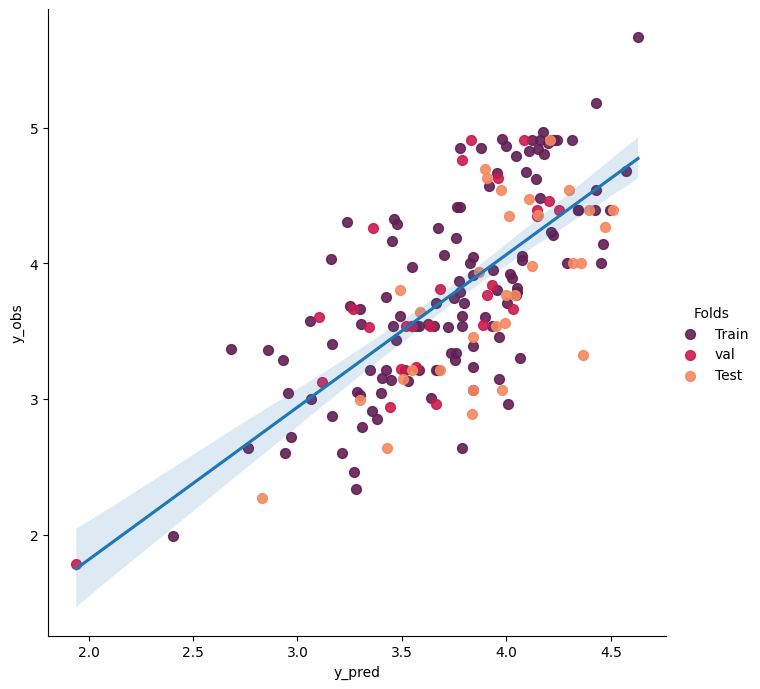

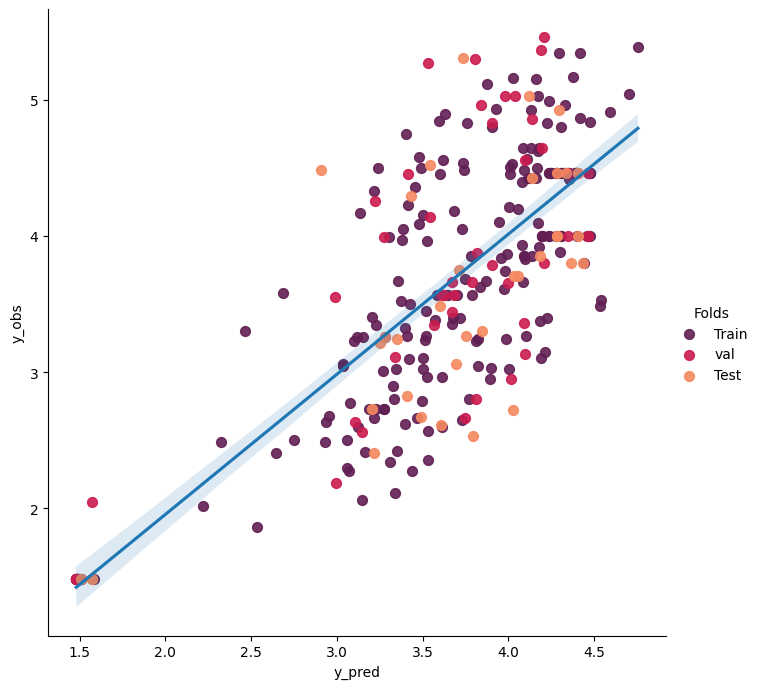

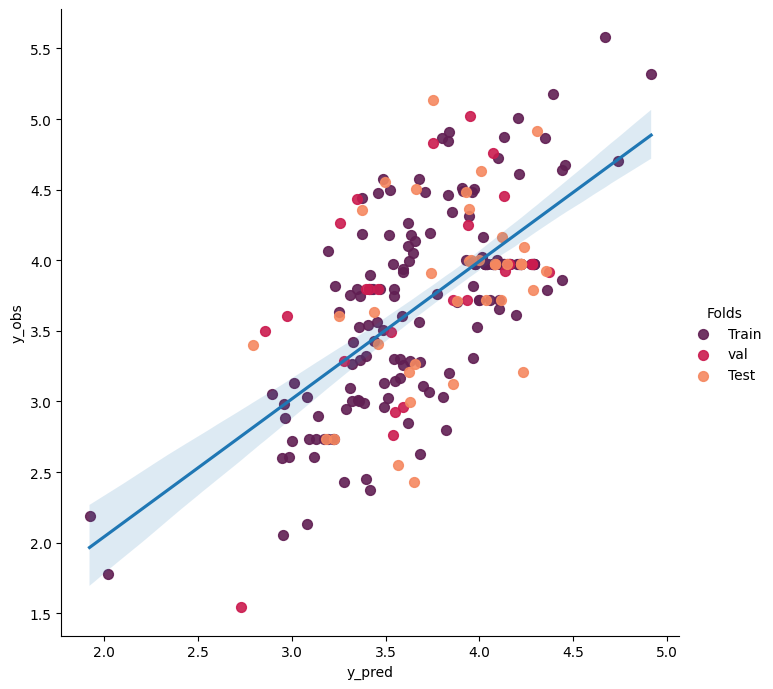

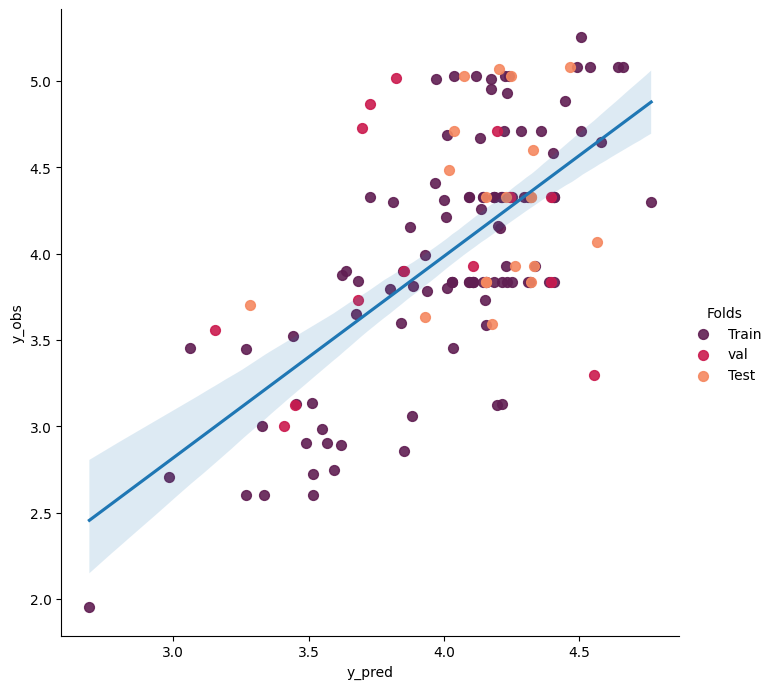

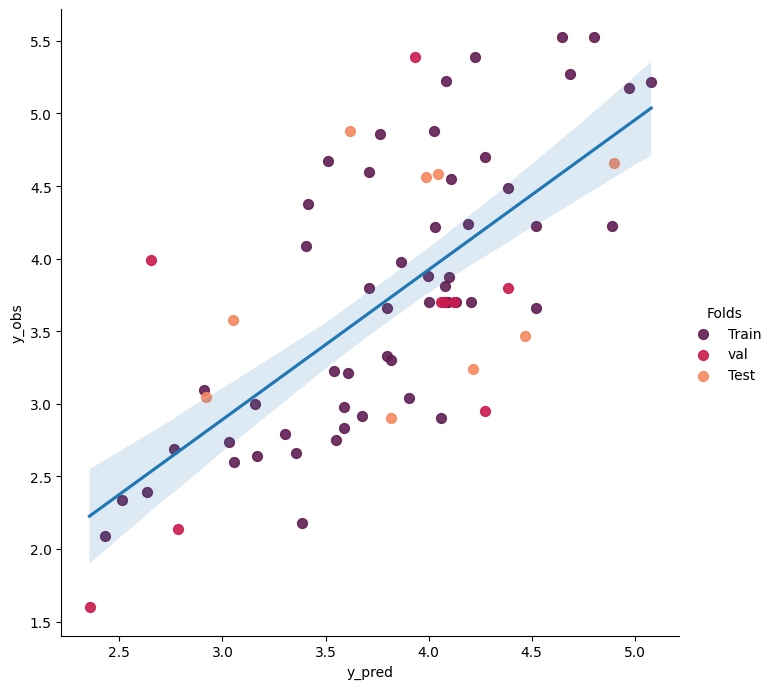

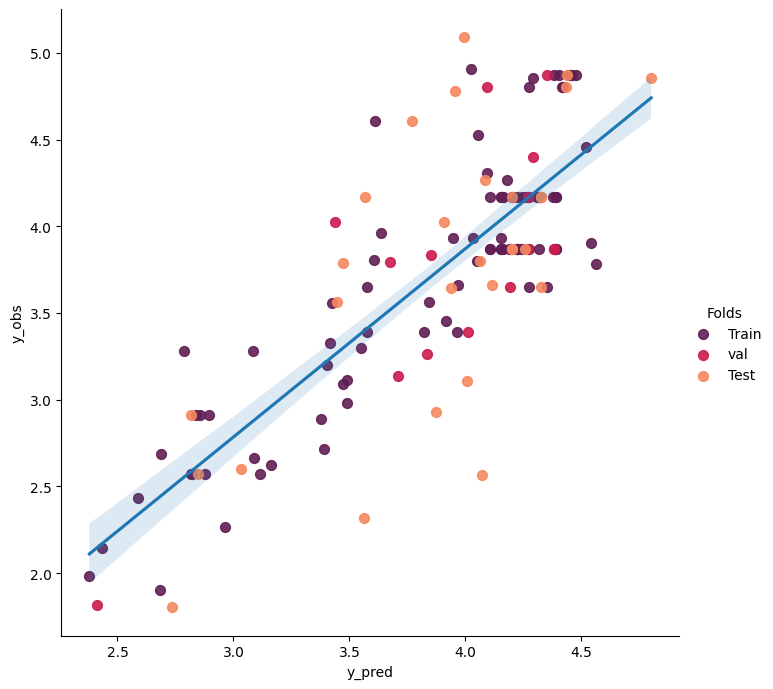

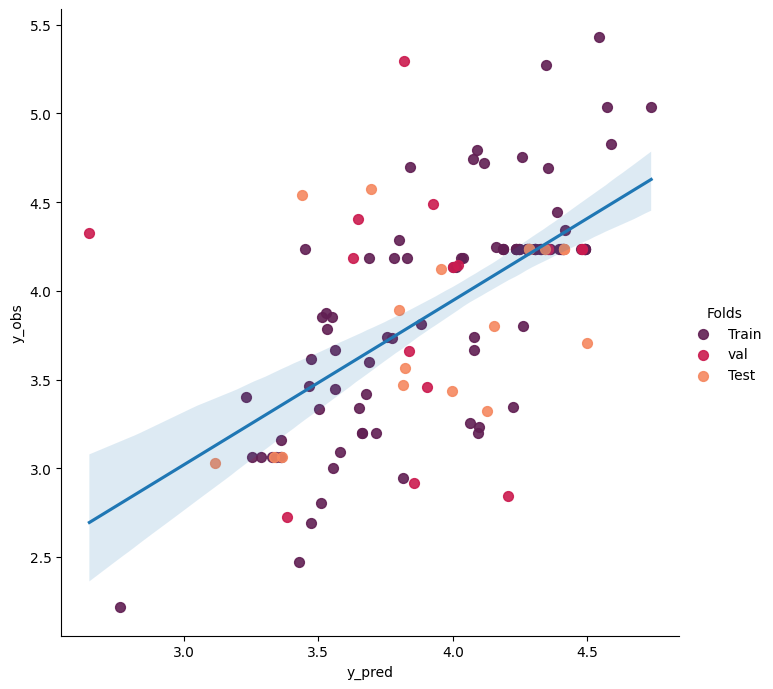

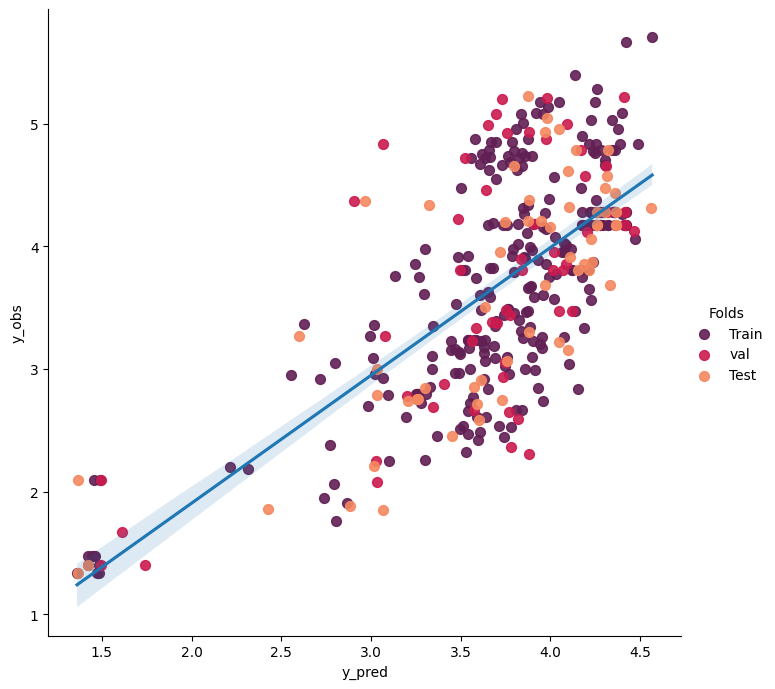

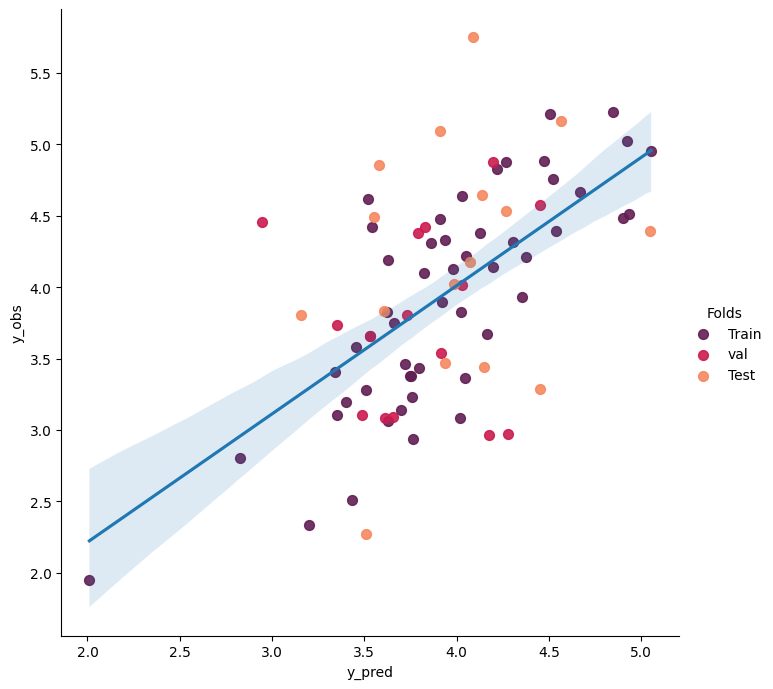

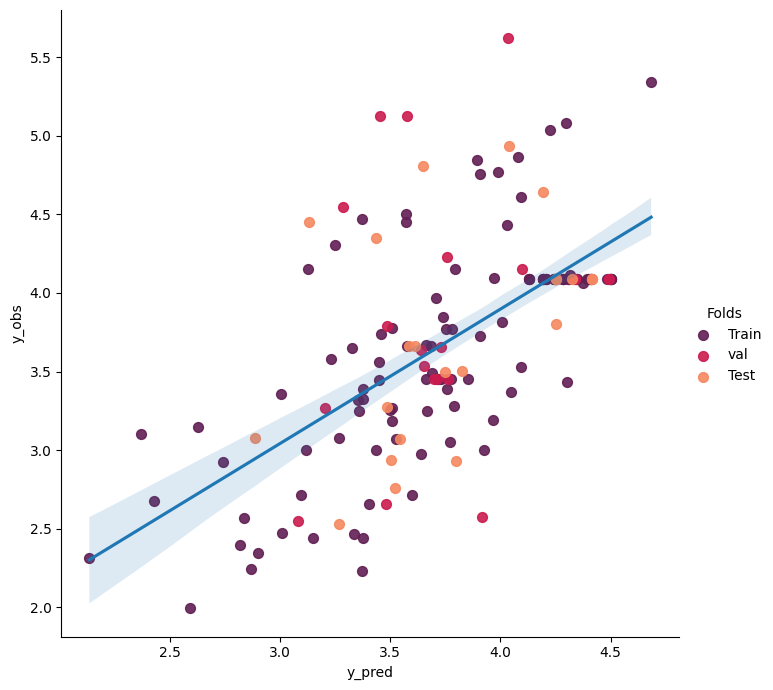

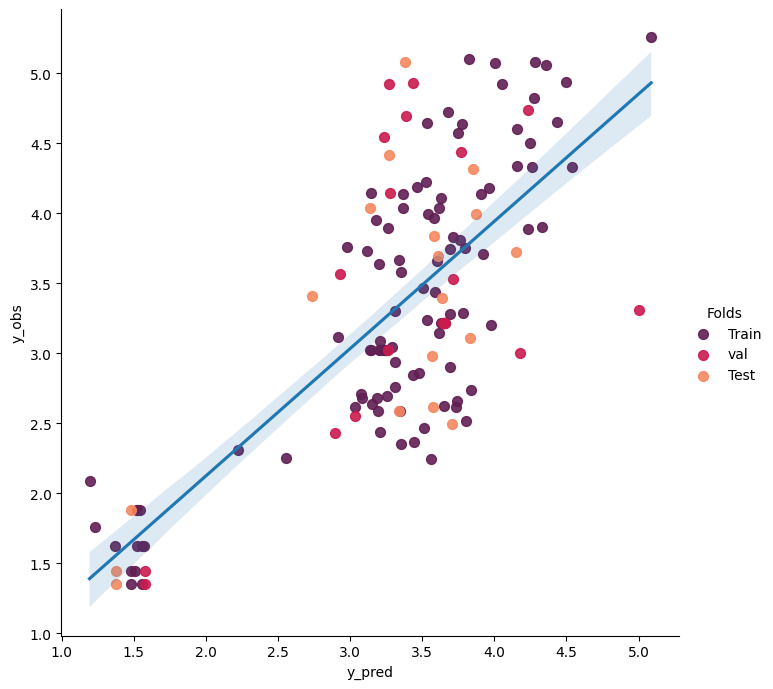

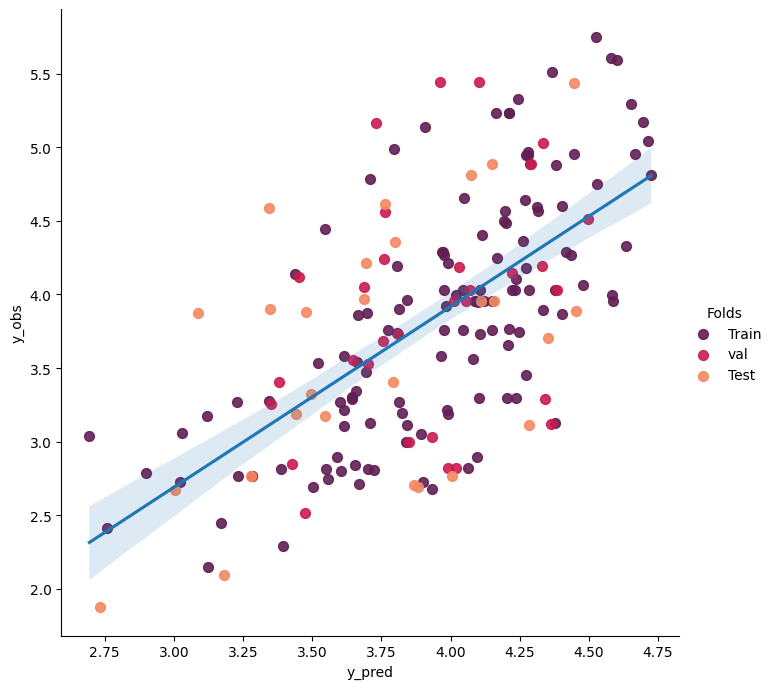

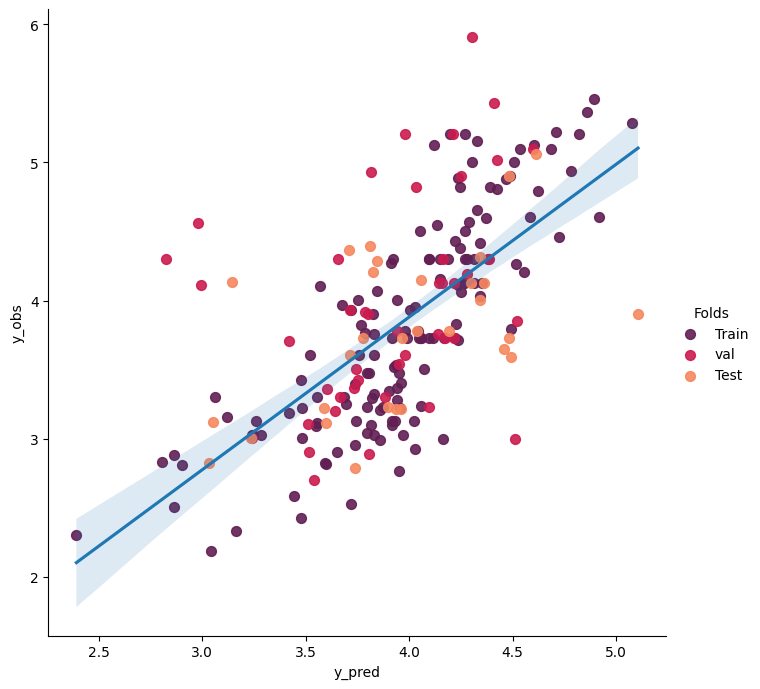

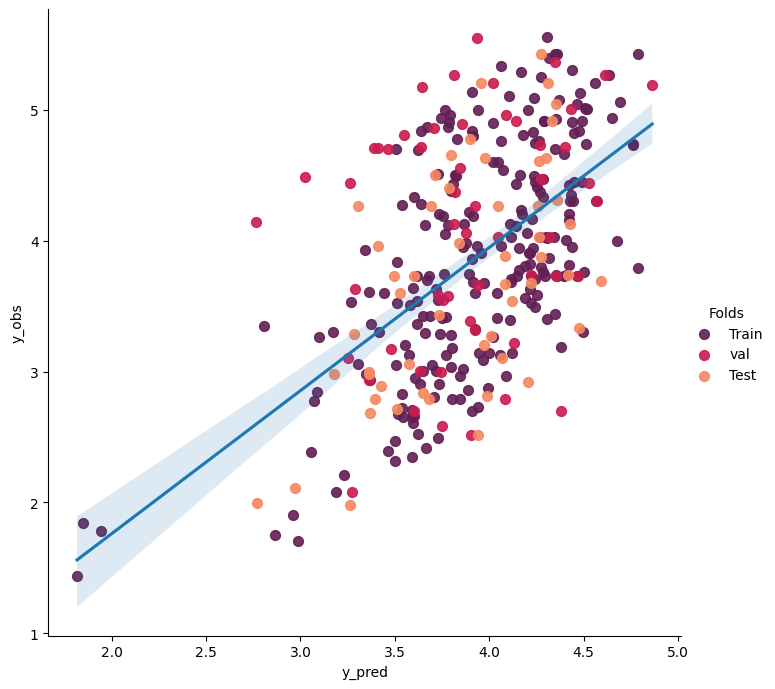

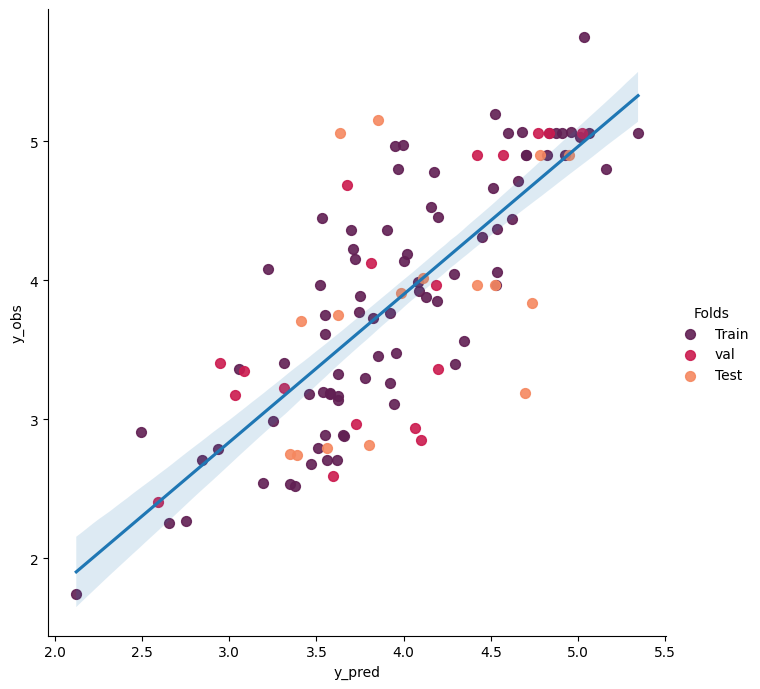

In [30]:
#Statistical characteristico of model using 3-sigma rule

for index1 in range(prediction_train.shape[1]):

    train_pred = pd.DataFrame(y_train[:,index1],prediction_train[:,index1]) 
    train_pred['y_pred'] = train_pred.index
    train_pred = train_pred.rename(columns = {0: 'y_obs'})
    train_pred2 = train_pred.dropna()
    train_pred2 = train_pred2.reset_index(drop=True)
    train_pred2['Folds'] = 'Train'
    train_pred2 = train_pred2.assign(Folds_error = abs(train_pred2['y_pred'] - train_pred2['y_obs']))
    train_pred2['Folds error Mean'] = train_pred2['Folds_error'].mean() 
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds_error'].std()
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds error 3*sigma']*3
    train_pred2=train_pred2[train_pred2['Folds_error']<=(train_pred2['Folds error 3*sigma'])] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

    for index2 in range(prediction_val.shape[1]):
         
        val_pred = pd.DataFrame(y_val[:,index2],prediction_val[:,index2])
        val_pred['y_pred'] = val_pred.index
        val_pred = val_pred.rename(columns = {0: 'y_obs'})
        val_pred2 = val_pred.dropna()
        val_pred2 = val_pred2.reset_index(drop=True)
        val_pred2['Folds'] = 'val'
        val_pred2 = val_pred2.assign(Folds_error = abs(val_pred2['y_pred'] - val_pred2['y_obs']))
        val_pred2['Folds error Mean'] = val_pred2['Folds_error'].mean() 
        val_pred2['Folds error 3*sigma'] = val_pred2['Folds_error'].std()
        val_pred2['Folds error 3*sigma'] = val_pred2['Folds error 3*sigma']*3
        val_pred2=val_pred2[val_pred2['Folds_error']<=(val_pred2['Folds error 3*sigma'])]#keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
   
        for index3 in range(prediction_test.shape[1]):

            test_pred = pd.DataFrame(y_test[:,index3],prediction_test[:,index3])
            test_pred['y_pred'] = test_pred.index
            test_pred = test_pred.rename(columns = {0: 'y_obs'})
            test_pred2 = test_pred.dropna()
            test_pred2 = test_pred2.reset_index(drop=True)
            test_pred2['Folds'] = 'Test'
            test_pred2 = test_pred2.assign(Folds_error = abs(test_pred2['y_pred'] - test_pred2['y_obs']))
            test_pred2['Folds error Mean'] = test_pred2['Folds_error'].mean() 
            test_pred2['Folds error 3*sigma'] = test_pred2['Folds_error'].std()
            test_pred2['Folds error 3*sigma'] = test_pred2['Folds error 3*sigma']*3
            test_pred2=test_pred2[test_pred2['Folds_error']<=(test_pred2['Folds error 3*sigma'])] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

            crossval_df = pd.concat([train_pred2, val_pred2, test_pred2], axis=0).reset_index(drop=True)

            if index1 == index2 and index1 == index3:
                        
                r2 = (train_pred2["y_obs"].corr(train_pred2["y_pred"]))    
                print(("Results for task {} (train)").format(index2+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f" % sqrt(mean_squared_error(train_pred2["y_obs"],train_pred2["y_pred"])))
                print ("mse\t%.2f" % (mean_squared_error(train_pred2["y_obs"],train_pred2["y_pred"])))
                print ("mae\t%.2f"  %mean_absolute_error(train_pred2["y_obs"],train_pred2["y_pred"]))   

                r2 = (val_pred2["y_obs"].corr(val_pred2["y_pred"]))
                print(("Results for task {} (validation)").format(index3+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f"  % sqrt(mean_squared_error(val_pred2["y_pred"],val_pred2["y_obs"])))
                print ("mse\t%.2f"  % (mean_squared_error(val_pred2["y_pred"],val_pred2["y_obs"])))
                print ("mae\t%.2f"  % mean_absolute_error(val_pred2["y_pred"],val_pred2["y_obs"]))
                
                r2 = (test_pred2["y_obs"].corr(test_pred2["y_pred"])) 
                print(("Results for task {} (test)").format(index1+1))
                print("r^2\t%.2f" % r2)
                print ("rmse\t%.2f"  % sqrt(mean_squared_error(test_pred2["y_pred"],test_pred2["y_obs"]))) 
                print ("mse\t%.2f"  % (mean_squared_error(test_pred2["y_pred"],test_pred2["y_obs"])))
                print ("mae\t%.2f"  % mean_absolute_error(test_pred2["y_pred"],test_pred2["y_obs"]))

                g = sns.lmplot(x="y_pred", y="y_obs", hue="Folds", data=crossval_df, fit_reg=False, height=7, 
                markers=["o", "o", "o"], palette="rocket",scatter_kws={"s": 50,'alpha':0.9},  aspect=30/30)
                sns.regplot(x="y_pred", y="y_obs", data=crossval_df, scatter=False, ax=g.axes[0, 0]) 

In [ ]:
predictions.shape[0]

In [ ]:
#Statistical characteristics of train set

score = model.evaluate(X_train, y_train, batch_size=batch_size)
print("results: %.2f (%.2f) mse" % (np.mean(score), np.std(score)))

predictions = model.predict(X_train)
for index in range(predictions.shape[1]):
    a = pd.DataFrame(y_train[:,index],predictions[:,index]) 
    a['y'] = a.index
    b = a.dropna()
    r2= r2_score(b["y"], b[0])
    print(("Results for task {} (train)").format(index+1))
    print("r^2\t%.2f" % r2)
    print("mae\t%.2f" % mean_absolute_error(b["y"], b[0]))
    print("mse\t%.2f" % mean_squared_error(b["y"], b[0]))
    print("rmse\t%.2f" % sqrt(mean_squared_error(b["y"], b[0])))
    
colorscale = ['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98,0.98,0.98)]
ff.create_2d_density(y_train[:,1],predictions[:,1], colorscale=colorscale, point_size=6)

In [ ]:
prediction

In [ ]:
#Statistical characteristics of test set

score = model.evaluate(X_test, y_test, batch_size=batch_size)
print("results: %.2f (%.2f) mse" % (np.mean(score), np.std(score)))

predictions = model.predict(X_test)
for index in range(predictions.shape[1]):
    a = pd.DataFrame(y_test[:,index],predictions[:,index]) 
    a['y'] = a.index
    b = a.dropna()
    r2_ext= r2_score(b["y"], b[0])
    print(("Results for task {} (teste)").format(index+1))
    print("r^2\t%.2f" % r2_ext)
    print("mae\t%.2f" % mean_absolute_error(b["y"], b[0]))
    print("mse\t%.2f" % mean_squared_error(b["y"], b[0]))
    print("rmse\t%.2f" % sqrt(mean_squared_error(b["y"], b[0])))
    
colorscale = ['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98,0.98,0.98)]
ff.create_2d_density(y_test[:,1],predictions[:,1], colorscale=colorscale, point_size=6)

In [ ]:
#Statistical characteristics of test set

score = model.evaluate(test_dataset, batch_size=batch_size)
print("results: %.2f (%.2f) mse" % (np.mean(score), np.std(score)))

predictions = T.squeeze(model.predict(test_dataset))
for index in range(predictions.shape[1]):
    a = pd.DataFrame(y_test[:,index],predictions[:,index]) 
    a['y'] = a.index
    b = a.dropna()
    print(("Results for task {} (test)").format(index+1))
    print("r^2\t%.2f" % r2_score(b["y"], b[0]))
    print("mae\t%.2f" % mean_absolute_error(b["y"], b[0]))
    print("mse\t%.2f" % mean_squared_error(b["y"], b[0]))
    print("rmse\t%.2f" % sqrt(mean_squared_error(b["y"], b[0])))
    
pyplot.scatter(y_test[:,1],predictions[:,1])

# Outliers remove for 3 sigm

In [ ]:
#Plotando os graficos e parâmetros com outline dos conjuntos Teste e Treino
prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

import seaborn as sns
import matplotlib.pyplot as plt

for index in range(prediction_train.shape[1]):
    
    micromol = lambda val: (10**6)*10**(-val)
    train_pred = pd.DataFrame(y_train[:,index],prediction_train[:,index]) 
    train_pred['y_pred'] = train_pred.index
    train_pred = train_pred.rename(columns = {0: 'yobs'})
    train_pred2 = train_pred.dropna()
    train_pred2 = train_pred2.reset_index(drop=True)
    train_pred2['Folds'] = 'Train'
    train_pred2 = train_pred2.assign(Folds_error = abs(train_pred2['y_pred'] - train_pred2['yobs']))
    train_pred2['Folds error Mean'] = train_pred2['Folds_error'].mean() 
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds_error'].std()
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds error 3*sigma']*3

    
    for index2 in range(prediction_test.shape[1]):
         
        test_pred = pd.DataFrame(y_test[:,index2],prediction_test[:,index2])
        test_pred['y_pred'] = test_pred.index
        test_pred = test_pred.rename(columns = {0: 'yobs'})
        test_pred2 = test_pred.dropna()
        test_pred2 = test_pred2.reset_index(drop=True)
        test_pred2['Folds'] = 'Test'
        test_pred2 = test_pred2.assign(Folds_error = abs(test_pred2['y_pred'] - test_pred2['yobs']))
        test_pred2['Folds error Mean'] = test_pred2['Folds_error'].mean() 
        test_pred2['Folds error 3*sigma'] = test_pred2['Folds_error'].std()
        test_pred2['Folds error 3*sigma'] = test_pred2['Folds error 3*sigma']*3
        
        crossval_df = pd.concat([train_pred2,test_pred2], axis=0)
        
        if index == index2:
            
            r2_ext= r2_score(train_pred2["yobs"], train_pred2["y_pred"])   
            print(("Results for task {} (treinamento)").format(index+1))
            print("r^2\t%.2f" % r2_ext)
            print ("rmse\t%.2f:  " % sqrt(mean_squared_error(train_pred2["yobs"],train_pred2["y_pred"])))
            print ("mse\t%.2f:  " % (mean_squared_error(train_pred2["yobs"],train_pred2["y_pred"])))
            print ("mae\t%.2f: "  %mean_absolute_error(test_pred2["yobs"],test_pred2["y_pred"]))   
        
            r2_ext= r2_score(test_pred2["y_pred"],test_pred2["yobs"])
            print(("Results for task {} (test)").format(index2+1))
            print("r^2\t%.2f" % r2_ext)
            print ("rmse\t%.2f: "  % sqrt(mean_squared_error(test_pred2["y_pred"],test_pred2["yobs"])))
            print ("mse\t%.2f: "  % (mean_squared_error(test_pred2["y_pred"],test_pred2["yobs"])))
            print ("mae\t%.2f: "  % mean_absolute_error(test_pred2["y_pred"],test_pred2["yobs"]))
        
            g = sns.lmplot(x="y_pred", y="yobs", hue="Folds",order=2, data=crossval_df, fit_reg=False, 
            markers=["o", "x"], palette="Dark2",scatter_kws={"s": 5,'alpha':0.6},  aspect=10/10)
            sns.regplot(x="y_pred", y="yobs", data=crossval_df, scatter=False, ax=g.axes[0, 0])
            
        

In [ ]:
#Plotando os graficos e parâmetros com outline conjunto validação 

prediction_val = model.predict(X_val)

for index in range(prediction_val.shape[1]):
    
    micromol = lambda val: (10**6)*10**(-val)
    val_pred = pd.DataFrame(y_val[:,index],prediction_val[:,index]) 
    val_pred['y_pred'] = val_pred.index
    val_pred = val_pred.rename(columns = {0: 'yobs'})
    val_pred2 = val_pred.dropna()
    val_pred2 = val_pred2.reset_index(drop=True)
    val_pred2['Folds'] = 'Val'
    val_pred2 = val_pred2.assign(Folds_error = abs(val_pred2['y_pred'] - val_pred2['yobs']))
    val_pred2['Folds error Mean'] = val_pred2['Folds_error'].mean() 
    val_pred2['Folds error 3*sigma'] = val_pred2['Folds_error'].std()
    val_pred2['Folds error 3*sigma'] = val_pred2['Folds error 3*sigma']*3
    
           
    r2_ext= r2_score(val_pred2["yobs"], val_pred2["y_pred"])   
    print(("Results for task {} (Validação)").format(index+1))
    print("r^2\t%.2f" % r2_ext)
    print ("rmse\t%.2f:  " % sqrt(mean_squared_error(val_pred2["yobs"],val_pred2["y_pred"])))
    print ("mse\t%.2f:  " % (mean_squared_error(val_pred2["yobs"],val_pred2["y_pred"])))
    print ("mae\t%.2f: "  %mean_absolute_error(val_pred2["yobs"],val_pred2["y_pred"]))  
        



In [ ]:
#Plotando os graficos e parâmetros sem outline 
prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

import seaborn as sns
import matplotlib.pyplot as plt

for index in range(prediction_train.shape[1]):
    
    micromol = lambda val: (10**6)*10**(-val)
    train_pred = pd.DataFrame(y_train[:,index],prediction_train[:,index]) 
    train_pred['y_pred'] = train_pred.index
    train_pred = train_pred.rename(columns = {0: 'yobs'})
    train_pred2 = train_pred.dropna()
    train_pred2 = train_pred2.reset_index(drop=True)
    train_pred2['Folds'] = 'Train'
    train_pred2 = train_pred2.assign(Folds_error = abs(train_pred2['y_pred'] - train_pred2['yobs']))
    train_pred2['Folds error Mean'] = train_pred2['Folds_error'].mean() 
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds_error'].std()
    train_pred2['Folds error 3*sigma'] = train_pred2['Folds error 3*sigma']*3
    train_pred2=train_pred2[train_pred2['Folds_error']<=(train_pred2['Folds error 3*sigma'])] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

    
    for index2 in range(prediction_test.shape[1]):
         
        test_pred = pd.DataFrame(y_test[:,index2],prediction_test[:,index2])
        test_pred['y_pred'] = test_pred.index
        test_pred = test_pred.rename(columns = {0: 'yobs'})
        test_pred2 = test_pred.dropna()
        test_pred2 = test_pred2.reset_index(drop=True)
        test_pred2['Folds'] = 'Test'
        test_pred2 = test_pred2.assign(Folds_error = abs(test_pred2['y_pred'] - test_pred2['yobs']))
        test_pred2['Folds error Mean'] = test_pred2['Folds_error'].mean() 
        test_pred2['Folds error 3*sigma'] = test_pred2['Folds_error'].std()
        test_pred2['Folds error 3*sigma'] = test_pred2['Folds error 3*sigma']*3
        test_pred2=test_pred2[test_pred2['Folds_error']<=(test_pred2['Folds error 3*sigma'])] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
        crossval_df = pd.concat([train_pred2,test_pred2], axis=0)
        
        if index == index2:
        
            r2_ext= r2_score(train_pred2["yobs"], train_pred2["y_pred"])   
            print(("Results for task {} (treinamento)").format(index+1))
            print("r^2\t%.2f" % r2_ext)
            print ("rmse\t%.2f:  " % sqrt(mean_squared_error(train_pred2["yobs"],train_pred2["y_pred"])))
            print ("mse\t%.2f:  " % (mean_squared_error(train_pred2["yobs"],train_pred2["y_pred"])))
            print ("mae\t%.2f: "  %mean_absolute_error(test_pred2["yobs"],test_pred2["y_pred"]))   
        
            r2_ext= r2_score(test_pred2["y_pred"],test_pred2["yobs"])
            print(("Results for task {} (test)").format(index2+1))
            print("r^2\t%.2f" % r2_ext)
            print ("rmse\t%.2f: "  % sqrt(mean_squared_error(test_pred2["y_pred"],test_pred2["yobs"]))) 
            print ("mse\t%.2f: "  % (mean_squared_error(test_pred2["y_pred"],test_pred2["yobs"])))
            print ("mae\t%.2f: "  % mean_absolute_error(test_pred2["y_pred"],test_pred2["yobs"]))

            g = sns.lmplot(x="y_pred", y="yobs", hue="Folds",order=2, data=crossval_df, fit_reg=False, 
            markers=["o", "x"], palette="Dark2",scatter_kws={"s": 5,'alpha':0.6},  aspect=10/10)
            sns.regplot(x="y_pred", y="yobs", data=crossval_df, scatter=False, ax=g.axes[0, 0]

In [ ]:
#Plotando os graficos e parâmetros sem outline conjunto validação 

prediction_val = model.predict(X_val)

for index in range(prediction_val.shape[1]):
    
    micromol = lambda val: (10**6)*10**(-val)
    val_pred = pd.DataFrame(y_val[:,index],prediction_val[:,index]) 
    val_pred['y_pred'] = val_pred.index
    val_pred = val_pred.rename(columns = {0: 'yobs'})
    val_pred2 = val_pred.dropna()
    val_pred2 = val_pred2.reset_index(drop=True)
    val_pred2['Folds'] = 'Val'
    val_pred2 = val_pred2.assign(Folds_error = abs(val_pred2['y_pred'] - val_pred2['yobs']))
    val_pred2['Folds error Mean'] = val_pred2['Folds_error'].mean() 
    val_pred2['Folds error 3*sigma'] = val_pred2['Folds_error'].std()
    val_pred2['Folds error 3*sigma'] = val_pred2['Folds error 3*sigma']*3
    val_pred2=val_pred2[val_pred2['Folds_error']<=(val_pred2['Folds error 3*sigma'])] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
    
           
    r2_ext= r2_score(val_pred2["yobs"], val_pred2["y_pred"])   
    print(("Results for task {} (treinamento)").format(index+1))
    print("r^2\t%.2f" % r2_ext)
    print ("rmse\t%.2f:  " % sqrt(mean_squared_error(val_pred2["yobs"],val_pred2["y_pred"])))
    print ("mse\t%.2f:  " % (mean_squared_error(val_pred2["yobs"],val_pred2["y_pred"])))
    print ("mae\t%.2f: "  %mean_absolute_error(val_pred2["yobs"],val_pred2["y_pred"]))
    